Version: 02.14.2023

# Lab 6.2: Implementing Topic Extraction with NTM

In this lab, you will use the Amazon SageMaker Neural Topic Model (NTM) algorithm to extract topics from the [20 Newsgroups](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups) dataset.

The Amazon SageMaker Neural Topic Model (NTM) is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. NTM is most commonly used to discover a user-specified number of topics that are shared by documents within a text corpus.

Each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Because the method is unsupervised, the topics are not specified up front and are not guaranteed to align with how a human might naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics. For more information, see [Neural Topic Model (NTM) Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm.html) in the Amazon SageMaker Developer Guide.


## About this dataset

The 20 Newsgroups dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. This collection has become a popular dataset for experiments in text applications of machine learning techniques, such as text classification and text clustering. In this lab, you will see what topics you can learn from this set of documents using the Neural Topic Model (NTM) algorithm.

Dataset source: Tom Mitchell. *20 Newsgroups Data*. September 9, 1999. Distributed by UCI KDD Archive. https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.data.html.

## Lab steps

1. [Fetching the dataset](#1.-Fetching-the-dataset)
2. [Examining and preprocessing the data](#2.-Examining-and-preprocessing-the-data)
3. [Preparing the data for training](#3.-Preparing-the-data-for-training)
4. [Training the model](#4.-Training-the-model)
5. [Using the model for inference](#5.-Using-the-model-for-inference)
6. [Exploring the model](#6.-Exploring-the-model)

## Submitting your work

1. In the lab console, choose **Submit** to record your progress and when prompted, choose **Yes**.

1. If the results don't display after a couple of minutes, return to the top of the lab instructions and choose **Grades**.

    **Tip:** You can submit your work multiple times. After you change your work, choose **Submit** again. Your last submission is what will be recorded for this lab.

1. To find detailed feedback on your work, choose **Details** followed by **View Submission Report**.

## 1. Fetching the dataset
([Go to top](#Lab-6.2:-Implementing-Topic-Extraction-with-NTM))

First, define the folder to hold the data. Then, clean up the folder, which might contain data from previous experiments.

In [1]:
!pip install --upgrade pip
!pip install --upgrade SageMaker
!pip install --upgrade nltk

In [2]:
import boto3
import os
import shutil

def check_create_dir(dir):
    if os.path.exists(dir):  # Clean up existing data folder
        shutil.rmtree(dir)
    os.mkdir(dir)

data_dir = '20_newsgroups'
check_create_dir(data_dir)

In the next two cells, you unpack the dataset and extract a list of the files.

In [3]:
!tar -xzf ../s3/20_newsgroups.tar.gz
!ls 20_newsgroups

alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc
misc.forsale		  sci.med


In [4]:
folders = [os.path.join(data_dir,f) for f in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, f))]
file_list = [os.path.join(d,f) for d in folders for f in os.listdir(d)]
print('Number of documents:', len(file_list))

Number of documents: 19997


## 2. Examining and preprocessing the data
([Go to top](#Lab-6.2:-Implementing-Topic-Extraction-with-NTM))
    
In this section, you will examine the data and perform some standard natural language processing (NLP) data cleaning tasks.

Remind yourself what the files look like in order to determine the best preprocessing steps to take.

In [5]:
!cat 20_newsgroups/comp.graphics/37917

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!elroy.jpl.nasa.gov!nntp-server.caltech.edu!andrey
From: andrey@cco.caltech.edu (Andre T. Yew)
Newsgroups: comp.graphics
Subject: Re: 16 million vs 65 thousand colors
Date: 3 Apr 1993 19:51:06 GMT
Organization: California Institute of Technology, Pasadena
Lines: 28
Message-ID: <1pkpraINNck9@gap.caltech.edu>
References: <1993Mar26.210323.27802@midway.uchicago.edu> <dotzlaw-020493084300@murphy.biochem.umanitoba.ca> <d9hh.733845825@dtek.chalmers.se>
NNTP-Posting-Host: punisher.caltech.edu

d9hh@dtek.chalmers.se (Henrik Harmsen) writes:

>1-4 bits per R/G/B gives horrible machbanding visible in almost any picture.

>5 bits per R/G/B (32768, 65000 colors) gives visible machbanding

>color-gradient picture has _almost_ no machbanding. This color-resolution is 

>see some small machbanding on the smooth color-gradient picture, but all in all,
>There _ARE_ situiations where 

Each newsgroup document can have the following sections:
- header - Contains the standard newsgroup header information. This should be removed.
- quoted text - Text from a previous message, which usually is prefixed with '>' or '|', and sometimes starts with *writes*, *wrote*, *said*, or *says*.
- message - Body of the message that you want to extract topics from.
- footer - Messages typically end with a signature.

Define the following functions, which you will use to remove the headers, quoted text, and footers.

In [6]:
import re
def strip_newsgroup_header(text):
    """
    Given text in "news" format, strip the headers, by removing everything
    before the first blank line.
    """
    _before, _blankline, after = text.partition('\n\n')
    return after

_QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                       r'|^In article|^Quoted from|^\||^>)')


def strip_newsgroup_quoting(text):
    """
    Given text in "news" format, strip lines beginning with the quote
    characters > or |, plus lines that often introduce a quoted section
    (for example, because they contain the string 'writes:'.)
    """
    good_lines = [line for line in text.split('\n')
                  if not _QUOTE_RE.search(line)]
    return '\n'.join(good_lines)


def strip_newsgroup_footer(text):
    """
    Given text in "news" format, attempt to remove a signature block.

    As a rough heuristic, we assume that signatures are set apart by either
    a blank line or a line made of hyphens, and that it is the last such line
    in the file (disregarding blank lines at the end).
    """
    lines = text.strip().split('\n')
    for line_num in range(len(lines) - 1, -1, -1):
        line = lines[line_num]
        if line.strip().strip('-') == '':
            break

    if line_num > 0:
        return '\n'.join(lines[:line_num])
    else:
        return text

Import the packages you need for preprocessing the dataset.

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...


Next, remove extra spaces, convert the text to lowercase, and lemmatize the text.

In [8]:
stop = stopwords.words('english')
lem = WordNetLemmatizer()

def clean(sent):
    # Implement this function
    sent = sent.lower()
    sent = re.sub('\s+', ' ', sent)
    sent = sent.strip()
    sent = re.compile('<.*?>').sub('',sent)
    # Remove special characters and digits
    sent=re.sub("(\\d|\\W)+"," ",sent)
    sent=re.sub("br","",sent)
    filtered_sentence = []
    
    for w in word_tokenize(sent):
        # You are applying custom filtering here. Feel free to try different things.
        # Check if it is not numeric, the length > 2, and it is not in stopwords.
        if(not w.isnumeric()) and (len(w)>2) and (w not in stop):  
            # Stem and add to filtered list
            filtered_sentence.append(lem.lemmatize(w))
    final_string = " ".join(filtered_sentence) # Final string of cleaned words
    return final_string

Read each of the newsgroups messages. Remove the header, quotes, and footers. Then, store the results in an array.

In [9]:
data = []
source_group = []
for f in file_list:
    with open(f, 'rb') as fin:
        content = fin.read().decode('latin1')   
        content = strip_newsgroup_header(content)
        content = strip_newsgroup_quoting(content)
        content = strip_newsgroup_footer(content)
        content = clean(content)
        # Remove header, quoting, and footer
        data.append(content)
        

As you can see, the entries in the dataset are now just plain text paragraphs. You need to process them into a data format that the NTM algorithm can understand.

In [10]:
data[10:13]

['right pretty impossible right would ideal could believe try religion determine course thought suit best possible religion warrant belief belief carry psychological benefit also psychological burden well psychological benefit gained racism could fully understood judged person actually believing racism course parallel happens poor one originated',
 'gregg provided even title article support contention also reason believe anti islamic slander job apart prejudice yes mere report time stating bcci followed islamic banking rule gregg know islam good know bcci bad therefore bcci islamic anyone say otherwise obviously spreading slanderous propaganda see someone want provide reference article agree also respond reference article agree mmm yes would intellectually stimulating debate doubtless spend time soc culture islam got special place kill file right next bobby want join post become convinced simply waste time try reason moslem hoping achieve',
 'wpr atlanta com bill rawlins newsgroups alt

The next step is to vectorize the data so that it is ready for training. You can use `CountVectorizer`, which you have used in previous labs, and limit the vocabulary size to `vocab_size`. 

Use a maximum document frequency of 95 percent of documents (`max_df=0.95`) and a minimum document frequency of 2 documents (`min_df=2`).

In [11]:
%%time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')

# vectorizer = CountVectorizer(input='content', max_features=vocab_size, max_df=0.95, min_df=2)
vectorizer = CountVectorizer(input='content', max_features=vocab_size)
vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names_out()

print('vocab size:', len(vocab_list))

Tokenizing and counting, this may take a few minutes...
vocab size: 2000
CPU times: user 1.34 s, sys: 16.1 ms, total: 1.35 s
Wall time: 1.9 s


Optionally, consider removing short documents. A short document is not likely to express more than one topic. Topic modeling tries to model each document as a mixture of multiple topics; therefore, topic modeling might not be suitable for short documents.

The following cell removes documents that contain fewer than 25 words.

In [12]:
threshold = 25
vectors = vectors[np.array(vectors.sum(axis=1)>threshold).reshape(-1,)]
print('removed short docs (<{} words)'.format(threshold))        
print(vectors.shape)

removed short docs (<25 words)
(10870, 2000)


The output from `CountVectorizer` are sparse matrices with their elements being integers. 

In [13]:
print(type(vectors), vectors.dtype)
print(vectors[0])

<class 'scipy.sparse._csr.csr_matrix'> int64
  (0, 1798)	1
  (0, 1821)	1
  (0, 1438)	1
  (0, 1797)	1
  (0, 952)	2
  (0, 1814)	4
  (0, 84)	1
  (0, 974)	1
  (0, 1657)	2
  (0, 557)	2
  (0, 1856)	1
  (0, 444)	1
  (0, 1718)	1
  (0, 626)	1
  (0, 1278)	1
  (0, 1660)	1
  (0, 345)	1
  (0, 488)	1
  (0, 396)	1
  (0, 1332)	1
  (0, 1859)	1
  (0, 558)	1
  (0, 117)	1
  (0, 179)	1
  (0, 21)	1
  :	:
  (0, 1272)	2
  (0, 1298)	1
  (0, 788)	2
  (0, 1916)	1
  (0, 1781)	1
  (0, 1946)	1
  (0, 1925)	1
  (0, 145)	1
  (0, 1062)	1
  (0, 652)	1
  (0, 1115)	1
  (0, 30)	1
  (0, 737)	1
  (0, 1474)	1
  (0, 962)	1
  (0, 295)	1
  (0, 907)	1
  (0, 1991)	1
  (0, 750)	1
  (0, 176)	1
  (0, 1169)	1
  (0, 1995)	1
  (0, 1699)	1
  (0, 904)	1
  (0, 1405)	1


All of the parameters (weights and biases) in the NTM model are `np.float32` type. Therefore, you need the input data to also be `np.float32` type. It is better to do this type-casting up front rather than repeatedly casting during mini-batch training.

In [14]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse._csr.csr_matrix'> float32


# 3. Preparing the data for training
([Go to top](#Lab-6.2:-Implementing-Topic-Extraction-with-NTM))


As a common practice in model training, you should have a training set, validation set, and test set. The training set is the set of data that the model is actually being trained on. You care about the model's performance on future, unseen data. Therefore, during training, you periodically calculate scores (or losses) on the validation set to validate the performance of the model on unseen data. By assessing the model's ability to generalize, you can stop training at the optimal point to avoid overtraining.

Note that when you only have a training set and no validation set, the NTM model will rely on scores on the training set to perform early stopping, which could result in overtraining. Therefore, you should always supply a validation set to the model.

In this lab, you will use 80 percent of the dataset as the training set, and the remaining 20 percent for the validation set and test set. You will use the validation set in training and use the test set to demonstrate model inference.

In [15]:
from sklearn.model_selection import train_test_split
def split_data(df):
    train, test_validate = train_test_split(df,
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=324
                                            )
    test, validate = train_test_split(test_validate,
                                            test_size=0.5,
                                            shuffle=True,
                                            random_state=324
                                            )
    return train, validate, test

In [16]:
train_vectors, val_vectors, test_vectors = split_data(vectors)

In [17]:
print(train_vectors.shape, val_vectors.shape)

(8696, 2000) (1087, 2000)


## Save the vocabulary file

To make use of the auxiliary channel for the vocabulary file, first save the text file with the name **vocab.txt** in the **auxiliary** directory.


In [18]:
import os
import shutil
aux_data_dir = os.path.join(data_dir, 'auxiliary')
check_create_dir(aux_data_dir)
with open(os.path.join(aux_data_dir, 'vocab.txt'), 'w', encoding='utf-8') as f:
    for item in vocab_list:
        f.write(item+'\n')


EDITOR COMMENTS for the following cell:
- In the first sentence, are "recordIO" and "protobuf" two different formats, or are they one format? It's written as if they are one format, but the words link to different URLs. From [this page in the SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html#cdf-recordio-format), I believe it should be written "protobuf recordIO format", but I don't understand why there are two URLs.
- The URL for "RecordIO" gives a 404 error. The following may be a replacement URL: https://mxnet.apache.org/versions/1.8.0/api/python/docs/api/mxnet/recordio/index.html#mxnet-recordio.
- The cell says "You will convert..." but then it looks like the actual conversion occurs several cells later. Consider relocating this cell to be closer to the code cell to which it applies.

## Store the data on Amazon S3

The NTM algorithm accepts data in the [recordIO - protobuf](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) format. The SageMaker Python API provides helper functions to convert your data into this format. You will convert the data from NumPy/SciPy and then upload it to an Amazon Simple Storage Service (Amazon S3) destination for the model to access during training.


EDITOR COMMENT for the following cell: The cell references "boto regexp", but I don't see that text in any of the code cells within this lab. Should "boto regexp" be in one of the code cells? Should "boto regexp" be replaced with something else here? Is that note applicable to this lab?

## Set up AWS credentials

You first need to specify data locations and access roles. In particular, you need the following data:

- The S3 `bucket` and `prefix` that you want to use for the training and model data. This should be within the same Region as the notebook instance, training, and hosting.
- The AWS Identity and Access Management (IAM) `role` is used to give training and hosting access to your data. See the documentation for how to create these. **Note:** If more than one role is required for notebook instances, training, and/or hosting, replace the `boto regexp` with the appropriate full IAM role Amazon Resource Number (ARN) string or strings.

**Note:** These values will have been supplied when the lab starts.

In [19]:
import os
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()
bucket = "c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [20]:
prefix = '20newsgroups-ntm'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
aux_prefix = os.path.join(prefix, 'auxiliary')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
s3_aux_data = os.path.join('s3://', bucket, aux_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Auxiliary data location', s3_aux_data)
print('Trained model will be saved at', output_path)

Training set location s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train
Validation set location s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/val
Auxiliary data location s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/auxiliary
Trained model will be saved at s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/output


Now, define a helper function to convert the data to the recordIO protobuf format and upload it to Amazon S3. In addition, you will have the option to split the data into several parts as specified by `n_parts`.

The algorithm inherently supports multiple files in the training folder ("channel"), which could be helpful for a large dataset. In addition, when you use distributed training with multiple workers (compute instances), having multiple files enables you to distribute different portions of the training data to different workers.

This helper function uses the `write_spmatrix_to_sparse_tensor` function, provided by the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk), to convert SciPy sparse matrix into the recordIO protobuf format.

In [21]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to S3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [22]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part0.pbr
Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part1.pbr
Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part2.pbr
Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part3.pbr
Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part4.pbr
Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part5.pbr
Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part6.pbr
Uploaded data to s3://c100688a2296028l5426256t1w437248787701-labbucket-zln85o8tvd8u/20newsgroups-ntm/train/train_part7.pbr
Uploaded data to

Upload the vocab.txt file.

In [23]:
boto3.resource('s3').Bucket(bucket).Object(aux_prefix+'/vocab.txt').upload_file(aux_data_dir+'/vocab.txt')

# 4. Training the model
([Go to top](#Lab-6.2:-Implementing-Topic-Extraction-with-NTM))

You have created the training and validation datasets and uploaded them to Amazon S3. Next, configure a SageMaker training job to use the NTM algorithm on the data that you prepared.

In [24]:
from sagemaker.image_uris import retrieve
container = retrieve('ntm',boto3.Session().region_name)

The code in the following cell automatically chooses an algorithm container based on the current Region. In the API call to `sagemaker.estimator.Estimator`, you also specify the type and count of instances for the training job. Because the 20 Newsgroups dataset is relatively small, you can use a CPU-only instance (`ml.c4.xlarge`).

NTM fully takes advantage of GPU hardware and, in general, trains roughly an order of magnitude faster on a GPU than on a CPU. Multi-GPU or multi-instance training further improves training speed roughly linearly if communication overhead is low compared to compute time.

In [25]:
import sagemaker
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=2, 
                                    instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker.Session())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


EDITOR COMMENT for following cell: This appears to be the only subsection within this task. In general, don't use subsections if only one exists. Recommend removing this heading or adding headings to other subsections within this task.

## Set the hyperparameters

The following is a partial list of hyperparameters. For the full list of available hyperparameters, see [NTM Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm_hyperparameters.html) in the Amazon SageMaker Developer Guide.

- **feature_dim** - The "feature dimension", which should be set to the vocabulary size
- **num_topics** - The number of topics to extract
- **mini_batch_size** - The batch size for each worker instance. Note that in multi-GPU instances, this number will be further divided by the number of GPUs. For example, if you plan to train on an 8-GPU machine (such as `ml.p2.8xlarge`) and want each GPU to have 1024 training examples per batch, `mini_batch_size` should be set to 8196.
- **epochs** - The maximum number of epochs to train for; training may stop early
- **num_patience_epochs** and **tolerance** - Control the early stopping behavior. In general, early stopping occurs when there hasn't been improvement on validation loss within the last `num_patience_epochs` number of epochs. Improvements smaller than `tolerance` are considered non-improvement.
- **optimizer** and **learning_rate** - The default optimizer is `adadelta`, and `learning_rate` does not need to be set. For other optimizers, the choice of an appropriate learning rate may require experimentation.

In [26]:
num_topics = 20
ntm.set_hyperparameters(num_topics=num_topics, 
                        feature_dim=vocab_size, 
                        mini_batch_size=256, 
                        num_patience_epochs=10, 
                        optimizer='adam')

Next, specify how the training data and validation data will be distributed to the workers during training. Data channels have two modes:

- `FullyReplicated`: All data files will be copied to all workers.
- `ShardedByS3Key`: Data files will be sharded to different workers. Each worker will receive a different portion of the full dataset.

The Python SDK uses the `FullyReplicated` mode for all data channels by default. This is desirable for the validation (test) channel but not for training channel. The reason is that when you use multiple workers, you would like to go through the full dataset by having each worker go through a different portion of the dataset to provide different gradients within epochs. When you use the `FullyReplicated` mode on training data, the training time per epoch is slower (nearly 1.5 times in this example), and it defeats the purpose of distributed training. To set the training data channel correctly, you specify `distribution` to be `ShardedByS3Key` for the training data channel.

In [27]:
from sagemaker.inputs import TrainingInput
# sagemaker.inputs.TrainingInput
s3_train = TrainingInput(s3_train_data, distribution='ShardedByS3Key') 
s3_val = TrainingInput(s3_val_data, distribution='FullyReplicated')

The final step before training is to define the auxiliary file. This will replace integers in the log files with the actual words.

In [28]:
s3_aux = TrainingInput(s3_aux_data, distribution='FullyReplicated', content_type='text/plain')

Now you are ready to train. The following cell takes a few minutes to run. The command will first provision the required hardware. You will see a series of dots indicating the progress of the hardware provisioning process. Once the resources are allocated, training logs will be displayed. With multiple workers, the log color and the ID following `INFO` identifies logs that are emitted by different workers.

In [29]:
# ntm.fit({'train': s3_train, 'validation': s3_train, 'auxiliary': s3_aux})
ntm.fit({'train': s3_train, 'validation': s3_val, 'auxiliary': s3_aux})

INFO:sagemaker:Creating training-job with name: ntm-2023-12-07-05-56-29-770


2023-12-07 05:56:30 Starting - Starting the training job...
2023-12-07 05:56:45 Starting - Preparing the instances for training.........
2023-12-07 05:58:27 Downloading - Downloading input data...
2023-12-07 05:58:57 Training - Downloading the training image.....................
2023-12-07 06:02:28 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[12/07/2023 06:02:35 INFO 140009233762112] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/default-input.json: {'encoder_layers': 'auto', 'mini_batch_size': '256', 'epochs': '50', 'encoder_layers_activation': 'sigmoid', 'optimizer': 'adadelta', 'tolerance': '0.001', 'num_patience_epochs': '3', 'batch_norm': 'false', 'rescale_gradient

If you see the message

> `===== Job Complete =====`

at the bottom of the output logs, then training has successfully completed, and the output NTM model was stored in the specified output path.

You can also view information about a training job on the SageMaker console. In the left navigation pane, under **Training**, choose **Training jobs**. Then, select the training job that matches the training job name from the following cell's output.

In [30]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2023-12-07-05-56-29-770


In the cell above that contains the log information for the training job, scroll until you find a line similar to the one in the following cell.

**Tip:** Look for the phrase `Topics from epoch:final`.

    [05/04/2021 02:01:05 INFO 140593644394304] Topics from epoch:final (num_topics:20) [wetc 0.33, tu 0.68]

Two numbers are of interest here: **wetc** and **tu**.

- **wetc** is the *word embedding topic coherence* and indicates the degree of topic coherence. A higher number indicates a higher degree of topic coherence.
- **tu** is the *topic uniqueness* metric and indicates how unique the terms are within the topic. A higher number indicates that the topic terms are more unique.

In the example cell, the wetc is average at 0.33, and the tu is above average at 0.68.

After the line that displays the overall wetc and tu metrics, you should see a list of topics that were identified along with the words that comprise that topic. Note that the topics are not named. That task still requires a human. For each topic, you see its wetc and tu scores, as well as the top words within that topic. 

Review these words, and try to determine a name for each topic.

**Note:** Your results may be different than those in the following cell.

    [05/04/2021 02:01:05 INFO 140593644394304] [0.60, 0.80] game win playoff player team espn season play detroit baseball cup league score pitcher nhl goal toronto played hockey montreal

Topic 0 seems to be about sports.

    [05/04/2021 02:01:05 INFO 140593644394304] [0.57, 1.00] christ jesus god scripture doctrine christian sin bible faith christianity atheist church religion islam holy heaven biblical eternal morality belief

Topic 1 seems to be about religion.

    [05/04/2021 02:01:05 INFO 140593644394304] [0.30, 0.97] scsi ide motherboard controller drive mhz connector isa slot bus cpu jumper pin meg adapter floppy simms external cache speed
    
Topic 2 seems to be about computers.

The following topic has a low uniqueness score. It's not clear what this topic would be. Is it something to do with motorcycles, food, or something else? You could name this '**unknown**'.

    [05/04/2021 02:01:05 INFO 140593644394304] [0.35, 0.39] clutch eat bike doctor stopped msg riding watching pitch wheel ride hit food pain feeling personally fix sometimes rear tend
    


# 5. Using the model for inference
([Go to top](#Lab-6.2:-Implementing-Topic-Extraction-with-NTM))

Now that you have a trained NTM model, use it to perform inference on data. For this example, that means predicting the topic mixture that represents a given document.

To create an inference endpoint, use the SageMaker Python SDK `deploy()` function from the job that you defined previously. Specify the instance type where inference is computed as well as an initial number of instances to launch.

In [31]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: ntm-2023-12-07-06-04-55-315
INFO:sagemaker:Creating endpoint-config with name ntm-2023-12-07-06-04-55-315
INFO:sagemaker:Creating endpoint with name ntm-2023-12-07-06-04-55-315


-------------!

Congratulations! You now have a functioning SageMaker NTM inference endpoint.

You can confirm the endpoint configuration and status in the SageMaker console. In the left navigation pane, under **Inference**, choose **Endpoints**. Then, select the endpoint that matches the endpoint name from the following cell's output.

In [32]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint_name))

Endpoint name: ntm-2023-12-07-06-04-55-315



### Data serialization and deserialization

You can pass data in a variety of formats to the inference endpoint. First, you will pass CSV-formatted data. Use the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` to configure the inference endpoint.

In [33]:
ntm_predictor.content_types = 'text/csv'
ntm_predictor.serializer = sagemaker.serializers.CSVSerializer()
ntm_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

Now,  pass five examples from the test set to the inference endpoint.

In [34]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
print(results)

{'predictions': [{'topic_weights': [0.0514694117, 0.051962819, 0.0396383405, 0.0441860631, 0.0434924178, 0.0531198457, 0.0491438061, 0.1018232554, 0.046644222, 0.0536713153, 0.0487449057, 0.0358812995, 0.0575957447, 0.0415451452, 0.0619677678, 0.0661710426, 0.0154691683, 0.0472264886, 0.0442499369, 0.0459970348]}, {'topic_weights': [0.0318500325, 0.0376338623, 0.0231083725, 0.0369933397, 0.0372384414, 0.0397675671, 0.0416224711, 0.0448245816, 0.0343550891, 0.0375960544, 0.0357508548, 0.0422775783, 0.0378828011, 0.0418341532, 0.0408849642, 0.0426723249, 0.3053934276, 0.0186631717, 0.0334900692, 0.0361608677]}, {'topic_weights': [0.0348205045, 0.0403190479, 0.0245860275, 0.0442737788, 0.0404745117, 0.0440425426, 0.0476625264, 0.0759000182, 0.0370758846, 0.037191052, 0.038959939, 0.0567218326, 0.0439429395, 0.0522889085, 0.0482399017, 0.0450523347, 0.1960291564, 0.0225428883, 0.0340912789, 0.0357849225]}, {'topic_weights': [0.0347538739, 0.0419525281, 0.0232556872, 0.0394195281, 0.0412891

The output format of the SageMaker NTM inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    ...
  ]
}
```

Extract the topic weights that correspond to each of the input documents.

In [35]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.05146941 0.05196282 0.03963834 0.04418606 0.04349242 0.05311985
  0.04914381 0.10182326 0.04664422 0.05367132 0.04874491 0.0358813
  0.05759574 0.04154515 0.06196777 0.06617104 0.01546917 0.04722649
  0.04424994 0.04599703]
 [0.03185003 0.03763386 0.02310837 0.03699334 0.03723844 0.03976757
  0.04162247 0.04482458 0.03435509 0.03759605 0.03575085 0.04227758
  0.0378828  0.04183415 0.04088496 0.04267232 0.30539343 0.01866317
  0.03349007 0.03616087]
 [0.0348205  0.04031905 0.02458603 0.04427378 0.04047451 0.04404254
  0.04766253 0.07590002 0.03707588 0.03719105 0.03895994 0.05672183
  0.04394294 0.05228891 0.0482399  0.04505233 0.19602916 0.02254289
  0.03409128 0.03578492]
 [0.03475387 0.04195253 0.02325569 0.03941953 0.04128918 0.0586574
  0.04755551 0.06351855 0.03866264 0.04613799 0.04176599 0.04285103
  0.04948071 0.04322923 0.06266289 0.05878149 0.02672766 0.15749788
  0.038238   0.0435623 ]
 [0.02526221 0.02566385 0.01854364 0.02454945 0.02733094 0.03066917
  0.02826551 0.390

Replace the topic names in the following cell with the topic names that you determined.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
colnames = pd.DataFrame({'topics':['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4', 'topic 5', 'topic 6','topic 7','topic 8','topic 9',
       'topic 10', 'topic 11', 'topic 12', 'topic 13', 'topic 14', 'topic 15', 'topic 16','topic 17','topic 18','topic 19']})

INFO:matplotlib.font_manager:generated new fontManager


Now, use a bar plot to take a look at how the 20 topics are assigned to the 5 test documents.

Text(0.5, 0, 'Topic ID')

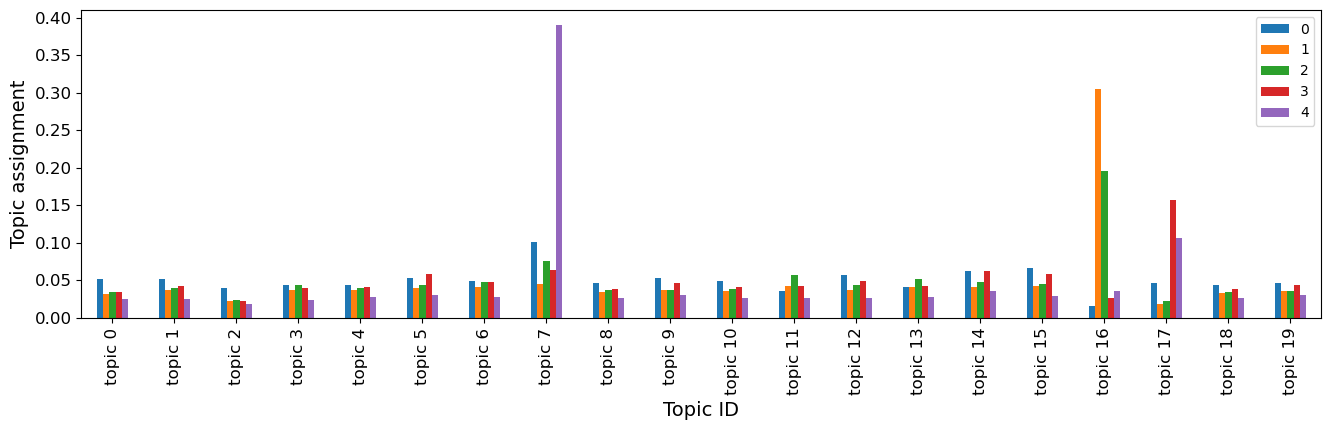

In [37]:
fs = 12
df=pd.DataFrame(predictions.T)
df.index = colnames['topics']
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

You could improve the model by adding or removing specific words to influence topics, increasing or decreasing the number of topics, and trying different hyperparameters.

## Delete the endpoint

Finally, delete the endpoint before you close the notebook.

To restart the endpoint, you can follow the code in section 5 using the same `endpoint_name`.

In [38]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Deleting endpoint with name: ntm-2023-12-07-06-04-55-315


# 6. Exploring the model
([Go to top](#Lab-6.2:-Implementing-Topic-Extraction-with-NTM))

**Note: This section provides a deeper exploration of the trained models. The demonstrated functionalities may not be fully supported or guaranteed. For example, the parameter names may change without notice.**

The trained model artifact is a compressed package of MXNet models from the two workers. To explore the model, you first need to install MXNet.

In [49]:
# If you use the conda_mxnet_p36 kernel, MXNet is already installed; otherwise, uncomment the following line to install it.
!pip install mxnet 
import mxnet as mx

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Download and unpack the artifact.

In [40]:
model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
model_path

'20newsgroups-ntm/output/ntm-2023-12-07-05-56-29-770/output/model.tar.gz'

In [41]:
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [42]:
!tar -xzvf 'downloaded_model.tar.gz'

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
model_algo-2
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
model_algo-1


In [43]:
# Use flag -o to overwrite the previously unzipped content
!unzip -o model_algo-2

Archive:  model_algo-2
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


Load the model parameters, and extract the weight matrix $W$ in the decoder.

In [50]:
model = mx.ndarray.load('params')

W = model['arg:projection_weight']

NameError: name 'mx' is not defined

In [ ]:
print(W)

Visualize each topic as a word cloud. The size of each word is proportional to the pseudo-probability of the word appearing under each topic.

In [51]:
!pip install wordcloud
import wordcloud as wc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 33.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wordcloud = wc.WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1

# Congratulations!

You have completed this lab, and you can now end the lab by following the lab guide instructions.

*©2023 Amazon Web Services, Inc. or its affiliates. All rights reserved. This work may not be reproduced or redistributed, in whole or in part, without prior written permission from Amazon Web Services, Inc. Commercial copying, lending, or selling is prohibited. All trademarks are the property of their owners.*
